## **Pendahuluan**

Pada praktikum ini, kita akan membangun sebuah model klasifikasi gambar menggunakan TensorFlow dan Keras.
Model ini akan digunakan untuk mengklasifikasikan gambar menjadi tiga kategori: **Rock, Paper, dan Scissors**.

Agar proses pelatihan menjadi lebih efisien dan cepat, kita akan memanfaatkan teknik **Transfer Learning** dengan menggunakan model pre-trained **MobileNetV2** sebagai feature extractor.

### **Dataset**

Dataset yang digunakan dalam praktikum ini berasal dari Kaggle, dan dapat diunduh melalui tautan berikut:

🔗 [Rock-Paper-Scissors Dataset – Kaggle](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors)

Setelah mendownload dataset dan mengekstraknya, **praktikan diwajibkan** untuk menyusun struktur folder dataset menjadi seperti berikut:

<pre>
dataset/
    rock/
    paper/
    scissor/
</pre>



### **Load Dataset**
---

Kode di bawah ini digunakan untuk memuat dataset citra dari struktur folder yang telah disiapkan sebelumnya.

Praktikan diminta untuk:

- Menentukan **ukuran gambar** (`img_size`) sesuai dengan model yang akan digunakan (misalnya 224x224 untuk MobileNetV2).
- Mengatur **ukuran batch** (`batch_size`) sesuai kapasitas RAM/VRAM masing-masing.
- Mengisi nilai **`seed`** untuk memastikan bahwa hasil pembagian data bisa direproduksi kembali dengan urutan yang sama setiap kali dijalankan.

Dataset akan dibagi menjadi tiga bagian:
- **Training set**: 70%
- **Validation set**: 15%
- **Testing set**: 15%

Proses pemuatan data dilakukan dengan menggunakan fungsi bawaan TensorFlow, yaitu `image_dataset_from_directory()`, yang akan secara otomatis membaca gambar berdasarkan nama subfoldernya sebagai label.

> **Catatan:**
> Praktikan diperbolehkan untuk **menyesuaikan sendiri persentase pembagian data** (misalnya 80% train, 10% val, 10% test) selama proporsinya tetap konsisten dan masuk akal.  
> Praktikan juga dapat mengubah **ukuran gambar (`img_size`)** jika ingin menggunakan arsitektur model yang berbeda, serta **mengganti nilai `seed`** untuk mencoba hasil pembagian data yang berbeda.

Setelah training set dan validation+test set dimuat, validation dan test akan dipisahkan secara manual berdasarkan fraksi yang telah ditentukan.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import os

# === PARAMETER YANG HARUS DITENTUKAN PRAKTIKAN ===
dataset_dir = "dataset"          # folder utama dataset
img_size    = (224, 224)         # ukuran gambar (isi sendiri)
batch_size  = 32                 # ukuran batch
seed        = 19                 # random seed untuk reproducibility

# Dapatkan daftar kelas dari folder
classes = sorted(os.listdir(dataset_dir))

# === ATURAN SPLIT DATA ===
train_frac = 0.70
val_frac   = 0.15
test_frac  = 0.15
vt_frac    = val_frac + test_frac   # val + test (untuk split manual nanti)

# === MEMUAT TRAIN DATASET ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",        # gunakan one-hot encoding
)

# === MEMUAT VALIDATION + TEST DATASET (gabungan) ===
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)

# === SPLIT VAL DAN TEST SECARA MANUAL ===
vt_batches  = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = int(vt_batches * (val_frac / vt_frac))   # hitung proporsi val dalam val+test

val_ds  = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)


Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Found 2188 files belonging to 3 classes.
Using 656 files for validation.


### **Preprocessing dan Augmentasi Data**
---

Sebelum gambar dapat digunakan untuk melatih model, dataset perlu melalui proses **preprocessing** terlebih dahulu. Preprocessing ini bertujuan untuk memastikan bahwa semua input gambar berada dalam skala nilai yang konsisten dan sesuai dengan ekspektasi dari model.

Pada praktikum ini, preprocessing dilakukan melalui dua tahap:

1. **Normalisasi**:  
   Setiap pixel gambar yang awalnya berada pada rentang nilai **[0, 255]** diubah ke rentang **[0, 1]** dengan menggunakan layer `Rescaling(1./255)`.

2. **Augmentasi** (opsional):  
   Untuk meningkatkan variasi data dan mengurangi overfitting, dilakukan augmentasi pada **data training saja**. Augmentasi dilakukan melalui transformasi berikut:
   - `RandomFlip("horizontal")`: membalik gambar secara horizontal.
   - `RandomRotation(0.1)`: memutar gambar secara acak hingga 10%.
   - `RandomZoom(0.1, 0.1)`: melakukan zoom in/out hingga 10%.
   - `RandomContrast(0.1)`: mengubah kontras gambar secara acak hingga ±10%.

Semua preprocessing dan augmentasi dilakukan melalui fungsi `prep()`.  
Fungsi ini menerima parameter `augment` untuk menentukan apakah augmentasi akan diterapkan atau tidak.  
- Jika `augment=True`, maka data akan dinormalisasi lalu diaugmentasi.  
- Jika `augment=False`, maka hanya normalisasi yang dilakukan (untuk validation dan test set).

Setelah diproses, setiap dataset akan di-cache dan di-prefetch menggunakan `AUTOTUNE` untuk mengoptimalkan performa saat training.

> **Catatan untuk praktikan:**  
> Praktikan dapat menyesuaikan jenis dan tingkat augmentasi pada `aug_layer` untuk melihat pengaruhnya terhadap performa model. Namun, augmentasi **hanya boleh diterapkan pada training set**.


In [7]:
from tensorflow.keras import layers

# praktikan diminta melengkapi isi preprocessing dan augmentasi
norm_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),  # lengkapi: normalisasi ke [0,1]
])

aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # flip kiri-kanan
    layers.RandomRotation(0.1),         # rotasi ±10%
    layers.RandomZoom(0.1, 0.1),        # zoom in/out sampai 10%
    layers.RandomContrast(0.1),         # kontras +-10%
])

# fungsi untuk mempersiapkan dataset
def prep(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (aug_layer(norm_layer(x), training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (norm_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    return ds.cache().prefetch(tf.data.AUTOTUNE)

# Praktikan diminta menentukan kapan augmentasi diaktifkan
train_ds = prep(train_ds, augment=True)
val_ds   = prep(val_ds,   augment=False)
test_ds  = prep(test_ds,  augment=False)


### **Build Model dan Training**
---

Pada tahap ini, kita akan membangun arsitektur model menggunakan teknik **Transfer Learning** dengan memanfaatkan **MobileNetV2** sebagai feature extractor.

Praktikan diminta untuk:

- **Melengkapi input layer** (`inputs`) dengan ukuran shape gambar yang sesuai.
- **Melengkapi output layer** (`outputs`) dengan jumlah neuron yang sama dengan jumlah kelas target (jumlah kategori pada dataset).

Bagian head klasifikasi model disusun dengan struktur:

- **GlobalAveragePooling2D**: Mengubah output feature map menjadi satu vektor rata-rata per channel.
- **Dropout**: Teknik regularisasi untuk mengurangi overfitting.
- **Dense (Softmax)**: Layer output yang mengklasifikasikan input ke dalam salah satu kelas.

---

### **Training Model**

Sebelum memulai proses pelatihan, kita juga telah mendefinisikan dua buah callbacks:

- `EarlyStopping`: Untuk menghentikan pelatihan jika validation loss tidak membaik setelah sejumlah epoch tertentu.
- `ModelCheckpoint`: Untuk menyimpan model terbaik berdasarkan validation loss.

Praktikan diminta untuk:

- **Melengkapi list callbacks** di fungsi `model.fit()`, dengan menambahkan kedua callbacks yang telah dibuat sebelumnya (`early_stopping` dan `model_checkpoint`).
- Menjalankan training selama **50 epoch** atau hingga proses berhenti otomatis karena `EarlyStopping`.

> **Catatan:**  
> Dengan menggunakan callbacks, kita dapat menghindari overfitting dan memastikan model terbaik tersimpan otomatis.



In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained base
base_model = MobileNetV2(
    input_shape=(*img_size, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# Tambahkan head klasifikasi baru
# Praktikan diminta melengkapi bagian input dan output di bawah ini
# Lengkapi bagian yang kosong dengan menyusun arsitektur head klasifikasi
inputs = tf.keras.Input(shape=(*img_size, 3))    # Tentukan input shape
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation="softmax")(x)  # Tentukan jumlah output classes
model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer  = "adam",
    loss       = "categorical_crossentropy",
    metrics    = ["accuracy"]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor    = "val_loss",
    patience   = 3,
    restore_best_weights=True
)
model_checkpoint = callbacks.ModelCheckpoint(
    "best_transfer.h5",
    monitor="val_loss",
    save_best_only=True
)

# Training model
# Praktikan diminta melengkapi callbacks yang digunakan
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]    # Lengkapi dengan callbacks yang telah dibuat
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.5915 - loss: 0.8860

48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 874ms/step - accuracy: 0.5952 - loss: 0.8795 - val_accuracy: 0.9594 - val_loss: 0.1569
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9560 - loss: 0.1917

48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 721ms/step - accuracy: 0.9561 - loss: 0.1912 - val_accuracy: 0.9844 - val_loss: 0.0874
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9755 - loss: 0.1118

48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 733ms/step - accuracy: 0.9755 - loss: 0.1116 - val_accuracy: 0.9875 - val_loss: 0.0628
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9824 - loss: 0.0814

48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.9824 - loss: 0.0813 - val_accuracy: 0.9875 - val_loss: 0.0457
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9891 - loss: 0.0619

48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 709ms/step - accuracy: 0.9891 - loss: 0.0618 - val_accuracy: 0.9875 - val_loss: 0.0419
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9892 - loss: 0.0521

48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 765ms/step - accuracy: 0.9892 - loss: 0.0520 - val_accuracy: 0.9906 - val_loss: 0.0363
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9882 - loss: 0.0525

48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 702ms/step - accuracy: 0.9882 - loss: 0.0523 - val_accuracy: 0.9906 - val_loss: 0.0309
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9939 - loss: 0.0364

48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 720ms/step - accuracy: 0.9939 - loss: 0.0364 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9918 - loss: 0.0351

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 652ms/step - accuracy: 0.9919 - loss: 0.0350 - val_accuracy: 0.9906 - val_loss: 0.0229
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9899 - loss: 0.0330

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 652ms/step - accuracy: 0.9900 - loss: 0.0329 - val_accuracy: 0.9906 - val_loss: 0.0226
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9928 - loss: 0.0303

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 653ms/step - accuracy: 0.9929 - loss: 0.0303 - val_accuracy: 0.9969 - val_loss: 0.0193
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9921 - loss: 0.0278

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 652ms/step - accuracy: 0.9922 - loss: 0.0277 - val_accuracy: 0.9937 - val_loss: 0.0188
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9961 - loss: 0.0203

48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 676ms/step - accuracy: 0.9962 - loss: 0.0203 - val_accuracy: 0.9969 - val_loss: 0.0161
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 628ms/step - accuracy: 0.9965 - loss: 0.0208 - val_accuracy: 0.9937 - val_loss: 0.0166
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 658ms/step - accuracy: 0.9964 - loss: 0.0186 - val_accuracy: 0.9969 - val_loss: 0.0166
Epoch 16/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 639ms/step - accuracy: 0.9976 - loss: 0.0162 - val_accuracy: 0.9937 - val_loss: 0.0166


### **Evaluasi Model**
---

Setelah model selesai dilatih, langkah berikutnya adalah mengevaluasi performanya pada **test set**.

Evaluasi dilakukan menggunakan dua pendekatan utama:

1. **Classification Report**  
   Menampilkan metrik klasifikasi seperti:
   - **Precision**: Seberapa akurat model saat membuat prediksi positif.
   - **Recall**: Seberapa baik model menangkap semua sampel positif.
   - **F1-Score**: Harmoni antara precision dan recall.
   - **Accuracy**: Persentase prediksi yang benar dari semua prediksi.

2. **Confusion Matrix**  
   Menunjukkan jumlah prediksi benar dan salah untuk masing-masing kelas, dalam bentuk tabel.  
   Dengan confusion matrix, kita bisa melihat pola kesalahan model (misal, apakah model sering salah membedakan "rock" dengan "paper", dll).

---

#### Langkah-langkah yang dilakukan pada kode:

- Menggunakan model untuk melakukan prediksi pada seluruh test dataset.
- Membandingkan hasil prediksi dengan label asli.
- Menampilkan classification report menggunakan `classification_report` dari scikit-learn.
- Menghitung dan memvisualisasikan confusion matrix menggunakan `ConfusionMatrixDisplay`.

> **Catatan untuk praktikan:**  
> Perhatikan nilai **precision**, **recall**, dan **f1-score** dari masing-masing kelas.  
> Jika terdapat ketidakseimbangan performa antar kelas, analisis kemungkinan penyebabnya (misalnya karena jumlah data tidak seimbang, kesamaan visual antar kelas, dsb).


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       paper     1.0000    0.9748    0.9872       119
        rock     0.9910    1.0000    0.9955       110
    scissors     0.9817    1.0000    0.9907       107

    accuracy                         0.9911       336
   macro avg     0.9909    0.9916    0.9911       336
weighted avg     0.9912    0.9911    0.9910       336



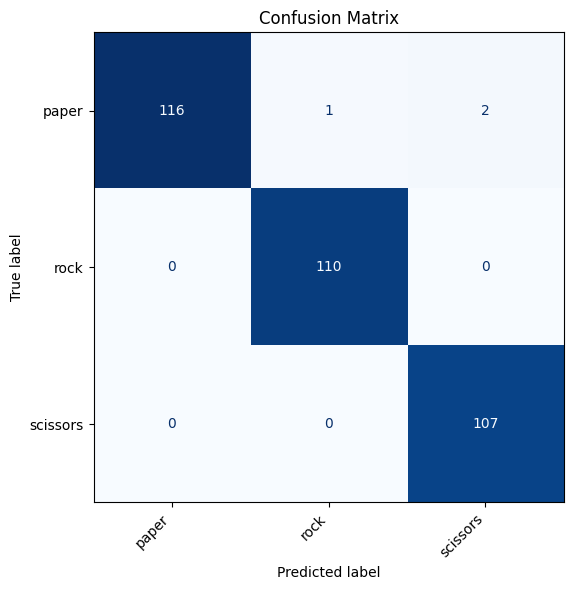

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# dapatkan prediksi probabilitas dan label dari test set
y_pred_probs = model.predict(test_ds)               # shape = (N, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)             # ambil indeks prediksi tertinggi (shape: (N,))

# ekstrak label asli dari test_ds
#    Karena test_ds bertipe (x_batch, y_batch) dengan label one-hot, kita ambil argmax dari y_batch
y_true = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in test_ds
], axis=0)

# tampilkan classification report
print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
))

# hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Setelah proses pelatihan selesai, model yang telah dilatih akan secara otomatis disimpan oleh callback `ModelCheckpoint` ke dalam file `.h5`.

Model ini dapat langsung digunakan dalam pengembangan aplikasi backend yang menggunakan **FastAPI** atau frontend berbasis **Streamlit**, untuk membuat aplikasi klasifikasi gambar.